In [1]:
from pathlib import Path
import numpy as np

# Plotting
import cmocean
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
color_map = cmocean.cm.ice

# Methods
from s4hci.models.psf_subtraction import S4
from s4hci.utils.pca import pca_psf_subtraction_gpu

from s4hci.utils.data_handling import save_as_fits
from applefy.utils.file_handling import load_adi_data

# Find all datasets

In [2]:
root_dir = Path("/fast/mbonse/NACO/30_data/")

In [3]:
list(root_dir.iterdir())

[PosixPath('/fast/mbonse/NACO/30_data/HD196544_131_087_C-0292_A_sel.hdf5'),
 PosixPath('/fast/mbonse/NACO/30_data/HD166348_128_1101_C-0092_A_sel.hdf5'),
 PosixPath('/fast/mbonse/NACO/30_data/HD38206_331_084_C-0396_A_sel.hdf5'),
 PosixPath('/fast/mbonse/NACO/30_data/HD39060_23_094_C-0149_D_sel.hdf5'),
 PosixPath('/fast/mbonse/NACO/30_data/HD22049_304_199_C-0065_C_sel.hdf5'),
 PosixPath('/fast/mbonse/NACO/30_data/HD199260_223_1101_C-0092_I_sel.hdf5'),
 PosixPath('/fast/mbonse/NACO/30_data/ELIA2-27_105_1101_C-0092_E_sel.hdf5'),
 PosixPath('/fast/mbonse/NACO/30_data/HD139664_221_1101_C-0092_I_sel.hdf5'),
 PosixPath('/fast/mbonse/NACO/30_data/HD207129_156_1101_C-0092_A_sel.hdf5'),
 PosixPath('/fast/mbonse/NACO/30_data/HD109832_146_1101_C-0092_F_sel.hdf5'),
 PosixPath('/fast/mbonse/NACO/30_data/HD197481_209_085_C-0675_A_sel.hdf5'),
 PosixPath('/fast/mbonse/NACO/30_data/HD138965_225_087_C-0292_A_sel.hdf5'),
 PosixPath('/fast/mbonse/NACO/30_data/HD188228_142_1101_C-0092_E_sel.hdf5'),
 PosixPat

In [4]:
test_dataset = list(root_dir.iterdir())[10]
test_dataset

PosixPath('/fast/mbonse/NACO/30_data/HD197481_209_085_C-0675_A_sel.hdf5')

In [5]:
tmp_result_dir = Path("/fast/mbonse/NACO/70_results") / test_dataset.name[:-9]
tmp_result_dir

PosixPath('/fast/mbonse/NACO/70_results/HD197481_209_085_C-0675_A')

In [6]:
tmp_result_dir.mkdir(exist_ok=True)

In [7]:
science_data, angles, raw_psf_template_data = load_adi_data(
    test_dataset,
    data_tag="object_lr_stacked_05",
    psf_template_tag="psf_template",
    para_tag="header_object_lr_stacked_05/PARANG")

# Background subtraction of the PSF template
psf_template_data = np.median(raw_psf_template_data, axis=0)

In [8]:
fwhm = 3.6
pixel_scale = 0.0271

# Run S4

In [9]:
lambda_reg = 1000

In [10]:
work_dir = tmp_result_dir / Path("S4")
work_dir.mkdir(exist_ok=True)

In [12]:
s4_model = S4(
    science_cube=science_data,
    adi_angles=angles,
    psf_template=psf_template_data,
    device=0,
    work_dir=work_dir,
    verbose=True,
    rotation_grid_subsample=1,
    noise_model_lambda_init=lambda_reg,
    noise_cut_radius_psf=fwhm,
    noise_mask_radius=fwhm*1.5,
    noise_normalization="normal",
    noise_model_convolve=True)

In [13]:
s4_model.fit_noise_model(
    num_epochs=100,
    use_rotation_loss=True,
    training_name=str(lambda_reg),
    logging_interval=1)

S4 model: Fit noise model ... 

  0%|          | 0/100 [00:00<?, ?it/s]

[DONE]


In [14]:
s4_residual = s4_model.compute_residual(combine="mean")

S4 model: computing residual ... [DONE]


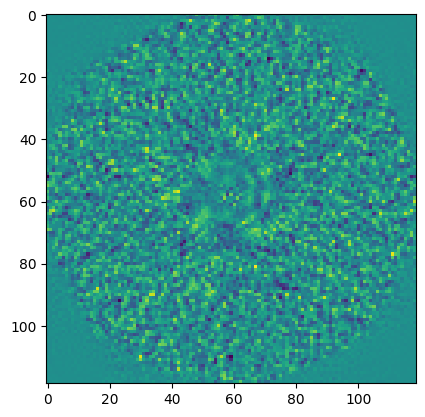

In [15]:
plt.imshow(s4_residual)

# Write out all dataset filenames

In [11]:
dataset_names = sorted([dataset.name[:-5] for dataset in root_dir.iterdir() if not dataset.name.startswith(".")])[::-1]

In [12]:
len(dataset_names)

493

In [13]:
dataset_names

['WASP6_193_091_C-0235_A_sel',
 'WASP18_247_099_C-0728_A_sel',
 'TWA22_72_094_C-0511_A_sel',
 'TWA22_71_094_C-0511_A_sel',
 'TWA22_70_094_C-0511_A_sel',
 'TWA22_69_094_C-0511_A_sel',
 'TWA22_67_094_C-0511_A_sel',
 'TWA22_57_094_C-0511_A_sel',
 'TWA22_43_094_C-0511_A_sel',
 'PDS77_156_1101_C-0092_A_sel',
 'PDS70_190_1101_C-0092_G_sel',
 'PDS70_189_1101_C-0092_G_sel',
 'PDS44_127_1101_C-0092_A_sel',
 'PDS44_126_1101_C-0092_A_sel',
 'PDS43_118_298_C-5054_B_sel',
 'HIP82323_201_1101_C-0092_H_sel',
 'HIP82323_195_0101_C-0466_A_sel',
 'HIP82323_168_0101_C-0466_A_sel',
 'HIP78053_136_199_C-0065_A_sel',
 'HIP77157_254_0103_C-0290_A_sel',
 'HIP6276_347_198_C-0612_C_sel',
 'HIP6276_331_084_C-0396_A_sel',
 'HIP55052_37_094_C-0625_A_sel',
 'HIP53911_125_097_C-0206_A_sel',
 'HIP23309_363_084_C-0739_A_sel',
 'HD98800B_122_097_C-0653_B_sel',
 'HD984_202_089_C-0149_A_sel',
 'HD98058_152_097_C-0206_A_sel',
 'HD98058_122_199_C-0065_A_sel',
 'HD97048_124_097_C-0206_A_sel',
 'HD97048_123_097_C-0206_A_sel'

In [14]:
selection_file = "/fast/mbonse/NACO/70_results/datasets.txt"

In [16]:
with open(selection_file, "w") as text_file:

    for dataset_name in dataset_names:
        text_file.write(dataset_name + "\n")